In [1]:
import SimpleITK as sitk
import os
from matplotlib import pyplot as plt
import numpy as np

In [2]:
# LABELS : creation of a list of vectors --> manual classification
# IMG 53 
y_g1_53 = np.zeros(512)
y_g1_53[172:214] = 1
y_g1_53[311:347] = 1

# IMG 54
y_g1_54 = np.zeros(512)
y_g1_54[160:203] = 1
y_g1_54[290:326] = 1

# IMG 55 
y_g1_55 = np.zeros(512)
y_g1_55[180:226] = 1
y_g1_55[291:332] = 1

# list of vectors (one per image to provide to the function)
label = np.concatenate((y_g1_53, y_g1_54, y_g1_55))

In [3]:
def image_to_slices (image):
    
    '''
    the function takes a 3D image and converts it to sagital slices 
    It returns a list of slices
    
    '''
    shape = image.GetSize()
    image_array = sitk.GetArrayFromImage(image)   
    image_slices = []
    for i in range (shape[0]):
        sl_array = image_array[:,:,i]
        # from image to array reverse the image up down 
        sl_array = np.flipud(sl_array)
        image_slices.append(sl_array)
    
    return image_slices


In [4]:
def get_slices_from_paths(im_list):
    """
    function to convert image paths list of numpy images of slices
    :param im_list: list of paths to .nii.gz images
    :return: slice_list: list of 2D numpy arrays containing image slices
    """
    slice_list = []
    # each image has to be converted in sagital slice
    for j in range(len(im_list)):
        # read image
        image = sitk.ReadImage(im_list[j], sitk.sitkFloat32, imageIO="NiftiImageIO")
        # create a list of slices
        slice_list += image_to_slices(image)

    return slice_list

In [65]:
import cv2
def preprocess_images(image, input_size):
    """
    Function to preprocess slices of image.
    :param image: list of 2D numpy arrays that contain saggital slices of hip/femur as numpy array
    :param input_size: input shape of image to reshape
    :return:
    """
    input_size = (input_size[1], input_size[0]) # opencv takes y first and then x
    image_preprocessed = [cv2.resize(slice, input_size) for slice in image]
    for slice in image_preprocessed:
        slice[slice < 100] = 0
        #if np.max(slice) != 0:
        #    slice -= np.min(slice)
        #    slice /= (np.max(slice) - np.min(slice))

    #image_preprocessed = [(slice - np.min(slice)) / (np.max(slice) - np.min(slice)) for slice in image_preprocessed]
    image_preprocessed = [slice[..., np.newaxis] for slice in image_preprocessed]

    print(image_preprocessed[0].max())

    return image_preprocessed

In [66]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import backend as K
from keras import applications, Model

def GetLeNet(n_base=32, input_shape=(128, 128, 1)):
    """Definition of leNet tensor flow network architecture
    """
    # Building the following LeNet architecture step by step
    model = Sequential()
    # First layer: 32 2D convolutional with size of 3by3 with "rectified linear unit" as activation function.
    model.add(Conv2D(n_base, kernel_size=(3, 3), activation='relu',  strides=1, padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    # Second layer: 2D layer: pooling layer (max-pooling) with the size of 2by2
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # 3rd layer: 64 2D convolutional with size of 3by3 with "rectified linear unit" as activation function.
    model.add(Conv2D(2*n_base, (3, 3), activation='relu', strides=1, padding='same'))
    model.add(BatchNormalization())
    # 4th layer: pooling layer (max-pooling) with the size of 2by2
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Vectorize the resulted image
    model.add(Flatten())
    # 5th layer: fully-connected layer (Dense) with the 128 nodes and "rectified linear unit" as activation function.
    model.add(Dense(4*n_base, activation='relu'))
    model.add(Dropout(0.6))

    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    return model

In [75]:
import tensorflow
def train_classifier(im_list, labels_list):
    """

    :param im_list: list of numpy 2D arrays slices of ct images
    :param labels_list: list of binary label whether or not images contain structure of interest
    :return: model: trained classifier that detects if structure is present
             shape: shape of input
    """


    '''
    train classifier
    NB --> sagital slices of different images have different size in y direction
    '''
    epochs = 50
    batch_size = 32
    shape  = im_list[0].shape
    images_preprocessed = np.array(preprocess_images(im_list, shape))

    #x_train = np.array(images_preprocessed[0:1024])
    #y_train = np.array(labels_list[0:1024])
    #x_val = np.array(images_preprocessed[1024:])
    #y_val = np.array(labels_list[1024:])

    model = GetLeNet(n_base=8, input_shape=(shape[0], shape[1], 1))
    model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])
    history = model.fit(x=images_preprocessed, y=labels_list,
              batch_size=batch_size,
              #validation_data=(x_val, y_val),
              epochs=epochs,verbose=1)

    return model, shape, history



In [76]:
atlas_images_base = os.path.join("data", "GROUP_images")
files_images = os.listdir(atlas_images_base)
atlas_images = [os.path.join(atlas_images_base, fil) for fil in files_images if ".nii" in fil]
print(atlas_images)
atlas_images.sort()
slices = get_slices_from_paths(atlas_images)
model, shape, history = train_classifier(slices, label)

['data/GROUP_images/g1_53_image.nii.gz', 'data/GROUP_images/g1_54_image.nii.gz', 'data/GROUP_images/g1_55_image.nii.gz']
121.0
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 311, 512, 8)       80        
                                                                 
 batch_normalization_20 (Bat  (None, 311, 512, 8)      32        
 chNormalization)                                                
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 155, 256, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 155, 256, 16)      1168      
                                                                 
 batch_normalization_21 (Bat  (None, 155, 256, 16)     64 

/Users/lasse/miniforge3/envs/cm2003/lib/python3.10/site-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
2023-01-09 15:00:55.218352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


48/48 [==============================] - 8s 147ms/step - loss: 0.3606 - accuracy: 0.8607
Epoch 2/50
48/48 [==============================] - 7s 146ms/step - loss: 0.1787 - accuracy: 0.9121
Epoch 3/50
48/48 [==============================] - 7s 145ms/step - loss: 0.1451 - accuracy: 0.9271
Epoch 4/50
48/48 [==============================] - 7s 143ms/step - loss: 0.1245 - accuracy: 0.9316
Epoch 5/50
48/48 [==============================] - 7s 145ms/step - loss: 0.0945 - accuracy: 0.9466
Epoch 6/50
48/48 [==============================] - 7s 140ms/step - loss: 0.0728 - accuracy: 0.9538
Epoch 7/50
48/48 [==============================] - 7s 139ms/step - loss: 0.0720 - accuracy: 0.9577
Epoch 8/50
48/48 [==============================] - 7s 139ms/step - loss: 0.0665 - accuracy: 0.9681
Epoch 9/50
48/48 [==============================] - 7s 142ms/step - loss: 0.0694 - accuracy: 0.9629
Epoch 10/50
48/48 [==============================] - 7s 136ms/step - loss: 0.0636 - accuracy: 0.9570
Epoch 11/5

dict_keys(['loss', 'accuracy'])
[0.36061951518058777, 0.17874740064144135, 0.14512664079666138, 0.12452290952205658, 0.09449484944343567, 0.07275629788637161, 0.0720018595457077, 0.06645391136407852, 0.06937427818775177, 0.06356963515281677, 0.056767530739307404, 0.05782393738627434, 0.0638846680521965, 0.05760972946882248, 0.053846314549446106, 0.05217932164669037, 0.05510009452700615, 0.051884450018405914, 0.05508766323328018, 0.05017261207103729, 0.048849210143089294, 0.05044751986861229, 0.05428063124418259, 0.05457616597414017, 0.05671505630016327, 0.05242375656962395, 0.0528886578977108, 0.05511952564120293, 0.058548107743263245, 0.04818885773420334, 0.045127686113119125, 0.0472625270485878, 0.04392078518867493, 0.08377381414175034, 0.04942458122968674, 0.048785656690597534, 0.0465853214263916, 0.04595055431127548, 0.06138213723897934, 0.04763294756412506, 0.04486597701907158, 0.057468514889478683, 0.0556827150285244, 0.05179312452673912, 0.05742665380239487, 0.04745900630950928,

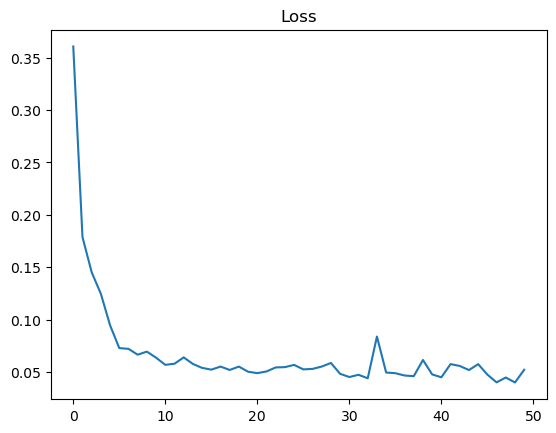

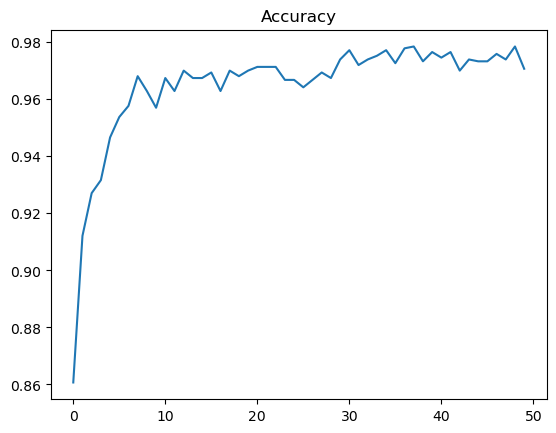

In [91]:
print(history.history.keys())
print(history.history["loss"])
print(history.history["accuracy"])

plt.plot(history.history["loss"])
plt.title("Loss")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Accuracy")
plt.show()

In [69]:
def obturator_foramen_selection(im, classifier):
    """
    Receive a preprocessed CT image and the trained classifier. Returns the sagittal slice number with the maximum probability of containing the obturator foramen (can be on the left or right).
    """
    pred = model.predict(np.array(im))
    prob = np.max(pred)
    slice_n = np.argmax(pred)
    return slice_n, prob

['data/COMMON_images_masks/common_41_image.nii.gz', 'data/COMMON_images_masks/common_40_image.nii.gz', 'data/COMMON_images_masks/common_42_image.nii.gz']
125.50962
Obturator foramen is in slice  202 with probability  0.81339204
427.22342
Obturator foramen is in slice  85 with probability  0.99773574
449.73615
Obturator foramen is in slice  85 with probability  0.9331442


Text(0.5, 1.0, 'Obturator foramen prediction for common_42_image.nii.gz')

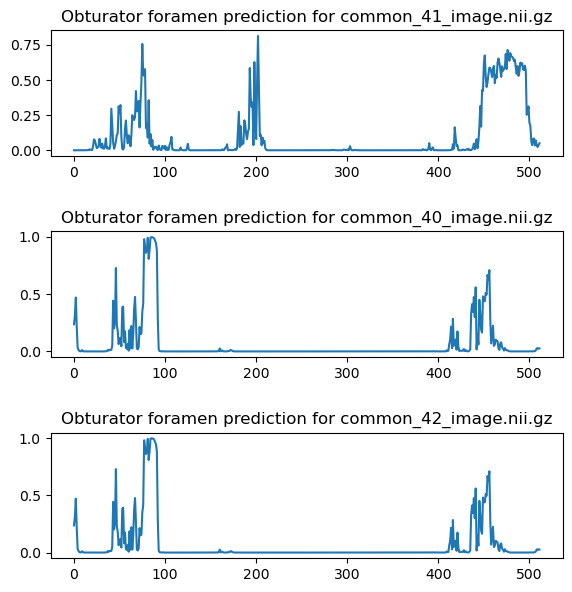

In [104]:
import matplotlib.pyplot as plt
common_images_base = os.path.join("data", "COMMON_images_masks")
files_common_images = os.listdir(common_images_base)
files_common_images = [os.path.join(common_images_base, fil) for fil in files_common_images if ".nii" in fil and "image" in fil]
print(files_common_images)

#print(atlas_images)
#slices = get_slices_from_paths([atlas_images[0]])
#images_preprocessed = preprocess_images(slices, shape)

# image 1
slices = get_slices_from_paths([files_common_images[0]])
images_preprocessed = preprocess_images(slices, shape)

slice_n, prob = obturator_foramen_selection(images_preprocessed, model)
print("Obturator foramen is in slice ", slice_n, "with probability ", prob)

y_pred_im1 = model.predict(np.array(images_preprocessed))

# image 2
slices = get_slices_from_paths([files_common_images[1]])
images_preprocessed = preprocess_images(slices, shape)

slice_n, prob = obturator_foramen_selection(images_preprocessed, model)
print("Obturator foramen is in slice ", slice_n, "with probability ", prob)
y_pred_im2 = model.predict(np.array(images_preprocessed))

# image 3
slices = get_slices_from_paths([files_common_images[2]])
images_preprocessed = preprocess_images(slices, shape)

slice_n, prob = obturator_foramen_selection(images_preprocessed, model)
print("Obturator foramen is in slice ", slice_n, "with probability ", prob)

y_pred_im3 = model.predict(np.array(images_preprocessed))

figure, axis = plt.subplots(3, 1)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=1.2,
                    wspace=0.5,
                    hspace=0.6)
axis[0].plot(range(len(y_pred_im1)), y_pred_im1)
axis[0].set_title("Obturator foramen prediction for common_41_image.nii.gz")

axis[1].plot(range(len(y_pred_im2)), y_pred_im2)
axis[1].set_title("Obturator foramen prediction for common_40_image.nii.gz")

axis[2].plot(range(len(y_pred_im2)), y_pred_im2)
axis[2].set_title("Obturator foramen prediction for common_42_image.nii.gz")

1
